In [23]:
import numpy as np
import pandas as pd
import category_encoders as ce

data = pd.read_csv("..\données\drought.csv")
data = data.drop(columns=['0','-9'])
data['DATE'] = pd.to_datetime(data['DATE'],format='d_%Y%m%d')
data['state'] =pd.Categorical(data['state'])
data['DSCI'] = data.D0 + data.D1 + data.D2 + data.D3 + data.D4

# Pour simplifier, nous étudions des séries temporelles univariées
data = data.drop(columns=['D0','D1','D2','D3','D4','W0','W1','W2','W3','W4'])
data

,DATE,state,DSCI
0,1895-01-01,alabama,0.0
1,1895-02-01,alabama,0.0
2,1895-03-01,alabama,0.0
3,1895-04-01,alabama,0.0
4,1895-05-01,alabama,0.0
...,...,...,...
73339,2021-12-01,wyoming,108.7
73340,2022-01-01,wyoming,85.7
73341,2022-02-01,wyoming,86.1
73342,2022-03-01,wyoming,50.0


In [24]:
# Nous nous concentrons d'abord sur les données de l'état de l'Alabama
X = data[data.state=='california'].sort_values('DATE')
X = X.drop(columns=['state']).sort_values('DATE').set_index('DATE')
X = X.reset_index()
X["DATE"] = X["DATE"].astype(str)
X["year"] = X["DATE"].str[0:4].astype(int)
X["month"] = X["DATE"].str[5:7].astype(int)
X["day"] = X["DATE"].str[8:10].astype(int)
X["1mago"] = X["DSCI"].shift(1)
X["2mago"] = X["DSCI"].shift(2)
X["3mago"] = X["DSCI"].shift(3)
X["1yago"] = X["DSCI"].shift(12)
X["2yago"] = X["DSCI"].shift(24)
X["3yago"] = X["DSCI"].shift(36)
X["moyeen"] = (X["DSCI"].shift(1)+X["DSCI"].shift(2)+X["DSCI"].shift(3))/3
X= ce.OneHotEncoder(cols='month',handle_unknown='return_nan',return_df=True,use_cat_names=True).fit_transform(X)
X= ce.OneHotEncoder(cols='year',handle_unknown='return_nan',return_df=True,use_cat_names=True).fit_transform(X)
X = X.dropna()

y = X.DSCI
X = X.drop(columns=["DATE","DSCI"])
X

,year_1895.0,year_1896.0,year_1897.0,year_1898.0,year_1899.0,year_1900.0,year_1901.0,year_1902.0,year_1903.0,year_1904.0,...,month_11.0,month_12.0,day,1mago,2mago,3mago,1yago,2yago,3yago,moyeen
36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,111.5,11.1,0.2,0.0,35.2,0.0,40.933333
37,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,132.3,111.5,11.1,0.0,76.7,0.0,84.966667
38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,131.2,132.3,111.5,0.0,39.3,0.0,125.000000
39,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,205.7,131.2,132.3,0.0,32.9,0.0,156.400000
40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,231.7,205.7,131.2,0.0,29.6,0.0,189.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1,156.3,165.6,242.5,230.0,8.3,57.1,188.133333
1524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,14.5,156.3,165.6,251.3,18.9,21.4,112.133333
1525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,43.4,14.5,156.3,347.4,191.1,1.2,71.400000
1526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,104.0,43.4,14.5,372.3,158.6,1.8,53.966667


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False)
rf_model = RandomForestRegressor(max_depth=3,n_estimators=140,min_samples_split=18)
rf_model.fit(X_train,y_train)#模型拟合
res = rf_model.predict(X_test)

2981.3073953609064

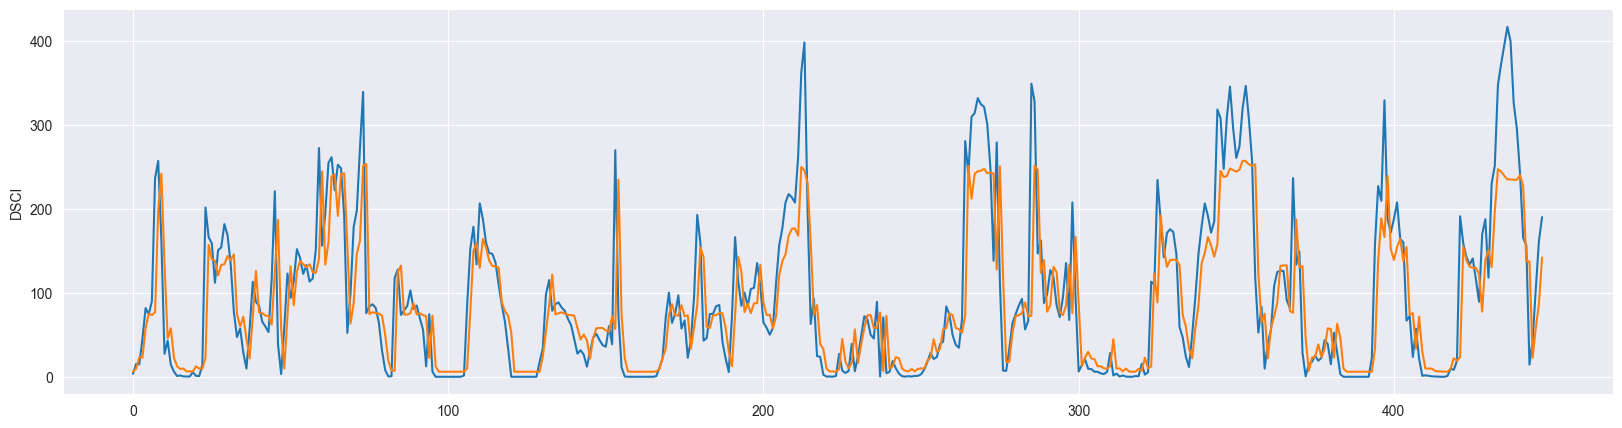

In [26]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(20,5))
ax11=sns.lineplot(y_test)
sns.lineplot(res,ax=ax11)
mean_squared_error(res,y_test)
# rf_model.oob_score_

In [27]:
RMSE = mean_squared_error(res,y_test)**0.5
RMSE

54.60134975768371

In [28]:
# from sklearn.model_selection import GridSearchCV
# param_test1 = {'n_estimators':range(10,200,10)}
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(),
#                         param_grid = param_test1)
# gsearch1.fit(X_train,y_train)
# gsearch1.best_params_, gsearch1.best_score_

In [29]:
# param_test2 = {'max_depth':range(1,10,1), 'min_samples_split':range(2,40,2)}
# gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=140),
#                                      param_grid = param_test2)
# gsearch2.fit(X_train,y_train)
# gsearch2.best_params_, gsearch2.best_score_